## Run Analysis on All Relevant OpSims (WFD Only)
**Author(s):** Weixiang Yu & Gordon Richards
<br>**Last updated:** 03-25-21
<br>**Short description:**
This notebook analyze the DCR metric results evaluated on All OpSims in preparation for the SCOC cadence notes on DCR in LSST.

### 0. Software Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os, sys

mpl.rc_file('../src/lsst_dcr.rc')
%matplotlib inline

In [2]:
# automatically extract username
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
        '\nIf it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311.
If it is incorrect, please mannually reset it.


##### Import the sims_maf modules needed.

In [3]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# import convenience functions
from opsimUtils import *

### 1. Read data from disk

In [4]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

resultDbPath = f'/home/idies/workspace/Temporary/{your_username}/scratch/MAFOutput/DCR/RunAll_v1_031621/ResultDBs/'
metricDataPath = f'/home/idies/workspace/Temporary/{your_username}/scratch/MAFOutput/DCR/RunAll_v1_031621/MetricData/'

In [5]:
# import metric evaluations
bundleDicts = {}

resultDbsView = getResultsDbs(resultDbPath)
for runName in resultDbsView:
    bundleDicts[runName] = bundleDictFromDisk(resultDbsView[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [6]:
# check keys
dbRuns = list(resultDbsView.keys())
bd_keys = list(bundleDicts[dbRuns[0]].keys())
print(bd_keys)

[(1, 'DCR_20.15_u'), (2, 'DCR_22.15_u'), (3, 'DCR_24.15_u'), (4, 'DCR_20_g'), (5, 'DCR_22_g'), (6, 'DCR_24_g')]


#### Keep only result for the relevant OpSims

In [7]:
# read in the list of relevant runs
runs_file = open('../data/run_info/run_list.txt', 'r')
runs_list = runs_file.read().split('\n')
runs_list[:5]

['agnddf_v1.5_10yrs',
 'barebones_nexp2_v1.6_10yrs',
 'barebones_v1.6_10yrs',
 'baseline_2snaps_v1.5_10yrs',
 'baseline_nexp1_v1.6_10yrs']

In [8]:
# select metric results for the relevant opsims
final_bundleDicts = {key:value for (key, value) in bundleDicts.items() if key in runs_list}
final_resultDbs = {key:value for (key, value) in resultDbsView.items() if key in runs_list}

### 2. Make plots

In [9]:
# take Lynne's notes on families
sys.path.insert(0, '../data/run_info/')
import run_infos as ri

families = ri.FamilyInfo()
fam_db = families.family
family_ls = list(fam_db.keys())

In [10]:
# get the metrics for plotting
Key1, Key2 = (2, 'DCR_22.15_u'), (5, 'DCR_22_g')
KeyNames = ['DCR_22.15_u', 'DCR_22_g']

#### 2.1 Get summary statistics (Median, Mean, etc.)

In [11]:
# get summary names
summaryNames = getSummaryStatNames(final_resultDbs['baseline_v1.5_10yrs'], 
                                   KeyNames[0])[0]['StatNames']

# loop through metric Keys and summaries -> combine into one pandas df
summary_dfs = []
for KeyName in KeyNames:
    for summaryName in summaryNames:
        summary_df = getSummary(
            final_resultDbs, 
            KeyName, 
            summaryName)[['summaryValue', 'runName']].rename(columns={'summaryValue':
                                                            f'{KeyName}_{summaryName}'})
        summary_dfs.append(summary_df.set_index('runName'))

summary_df_all = summary_dfs[0].join(summary_dfs[1:]).reset_index()

In [12]:
# assign family
comp_run = families.family_baseline
summary_df_all['family'] = ''
for familyName in comp_run:
    if familyName is not 'version_baselines':
        non_comp_runs = [run for run in fam_db[familyName] if run is not comp_run[familyName]]
        summary_df_all.loc[summary_df_all.runName.isin(non_comp_runs), 'family'] = familyName

# if not assigned, it must be one of the baselines
summary_df_all.loc[summary_df_all.family == '', 'family'] = 'baseline'

# sort by family
summary_df_all = summary_df_all.sort_values('family').set_index('runName')

#### 2.2 Pick the best (according to median values) from each family and plot summary/distributions

In [13]:
# define normalizing run
norm_run = 'baseline_2snaps_v1.5_10yrs'
norm_metric_u = summary_df_all.loc[norm_run, 'DCR_22.15_u_Median']
norm_metric_g = summary_df_all.loc[norm_run, 'DCR_22_g_Median']

##### 2.2.1 `DCR_22.15_u`
- Best one from each family (plus all baseline comparision runs)
- Best 10 and worst 10

Text(0.5,1,'Best one from every family (22.15_u)')

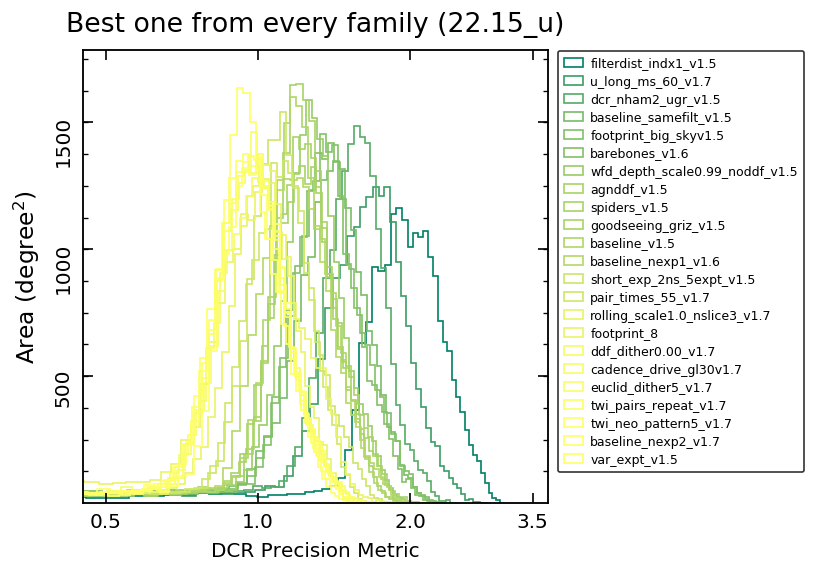

In [14]:
# sort by family and median
# take the best from each family, but keep all three baselines
best_u_family_no_baseline = summary_df_all[
    summary_df_all.family != 'baseline'
].sort_values(['family', 'DCR_22.15_u_Median']).drop_duplicates(subset='family')

best_u_family = pd.concat([summary_df_all[summary_df_all.family == 'baseline'], 
                           best_u_family_no_baseline], 
                          axis=0).sort_values('DCR_22.15_u_Median')

# plot distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)

# create normalization object
uNorm = mpl.colors.LogNorm(vmin=best_u_family['DCR_22.15_u_Median'].min(), 
                           vmax=best_u_family['DCR_22.15_u_Median'].max())
bins = 60
density = False

for run in best_u_family.index:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'DCR_22.15_u'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(uNorm(best_u_family.loc[run, 'DCR_22.15_u_Median']))
    ax.hist(norm_metric_u/data, bins=bins, histtype='step', color=c, 
             density=density, label=f"{run.rsplit('_', 1)[0]}")

# tick & format
ax.set_xscale('log', basex=10)
ax.set_xbound(lower=0.45, upper=3.75)
ax.tick_params(top=True, right=True, which='both')
ax.xaxis.set_major_locator(plt.FixedLocator([0.5, 1, 2, 3.5]))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(plt.NullLocator())

# label & legend
ax.set_xlabel('DCR Precision Metric', fontsize=12)
ax.legend(fontsize=7.5, bbox_to_anchor=(1.0, 1.02), edgecolor='k', loc=2, labelspacing=0.4)

ax.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1000, 1500, 2000])/(54.967783/60)**2))
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:.0f}'.format(x * (54.967783/60)**2) for x in y_vals], rotation=90)
ax.set_ylabel('Area ($\mathrm{degree^{2}}$)', labelpad=7)
plt.title('Best one from every family (22.15_u)')

Text(0.5,1,'Best 10 & Worst 10 (22.15_u)')

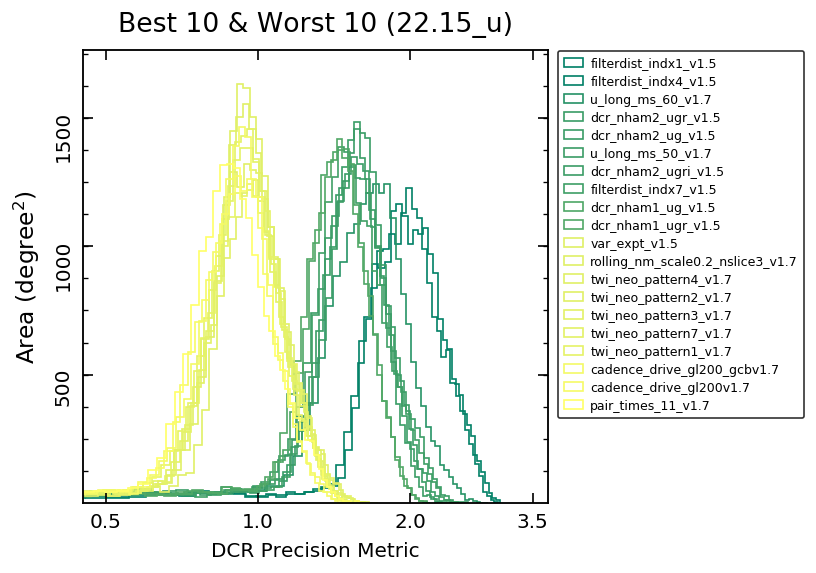

In [15]:
# plot distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)

# resort by metric value
summary_df_all = summary_df_all.sort_values('DCR_22.15_u_Median')

# create normalization object
uNormAll = mpl.colors.Normalize(vmin=summary_df_all['DCR_22.15_u_Median'].min(), 
                              vmax=summary_df_all['DCR_22.15_u_Median'].max())
bins = 60
density = False

# plot top 10
for run in summary_df_all.index[:10]:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'DCR_22.15_u'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(uNormAll(summary_df_all.loc[run, 'DCR_22.15_u_Median']))
    ax.hist(norm_metric_u/data, bins=bins, histtype='step', color=c, 
             density=density, label=f"{run.rsplit('_', 1)[0]}")

# plot worst 10
for run in summary_df_all.index[-10:]:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'DCR_22.15_u'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(uNormAll(summary_df_all.loc[run, 'DCR_22.15_u_Median']))
    ax.hist(norm_metric_u/data, bins=bins, histtype='step', color=c, 
             density=density, label=f"{run.rsplit('_', 1)[0]}")


# tick & format
ax.set_xscale('log', basex=10)
ax.set_xbound(lower=0.45, upper=3.75)
ax.tick_params(top=True, right=True, which='both')
ax.xaxis.set_major_locator(plt.FixedLocator([0.5, 1, 2, 3.5]))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(plt.NullLocator())

# label & legend
ax.set_xlabel('DCR Precision Metric', fontsize=12)
ax.legend(fontsize=7.5, bbox_to_anchor=(1.0, 1.02), edgecolor='k', loc=2, labelspacing=0.4)

ax.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1000, 1500, 2000])/(54.967783/60)**2))
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:.0f}'.format(x * (54.967783/60)**2) for x in y_vals], rotation=90)
ax.set_ylabel('Area ($\mathrm{degree^{2}}$)', labelpad=7)
plt.title('Best 10 & Worst 10 (22.15_u)')

##### 2.2.2 `DCR_22_g`
- Best one from each family (plus all baseline comparision runs)
- Best 10 and worst 10

Text(0.5,1,'Best one from every family (22_g)')

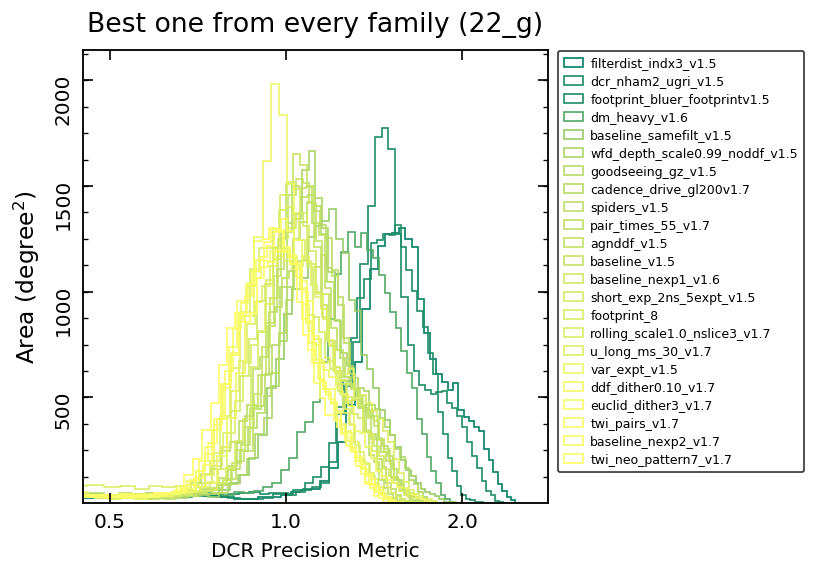

In [16]:
# sort by family and median
# take the best from each family, but keep all three baselines
best_g_family_no_baseline = summary_df_all[
    summary_df_all.family != 'baseline'
].sort_values(['family', 'DCR_22_g_Median']).drop_duplicates(subset='family')

best_g_family = pd.concat([summary_df_all[summary_df_all.family == 'baseline'], 
                           best_g_family_no_baseline], 
                          axis=0).sort_values('DCR_22_g_Median')

# plot distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)

# create normalization object
gNorm = mpl.colors.LogNorm(vmin=best_g_family['DCR_22_g_Median'].min(), 
                           vmax=best_g_family['DCR_22_g_Median'].max())
bins = 60
density = False

for run in best_g_family.index:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'DCR_22_g'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(gNorm(best_g_family.loc[run, 'DCR_22_g_Median']))
    ax.hist(norm_metric_g/data, bins=bins, histtype='step', color=c, 
            density=density, label=f"{run.rsplit('_', 1)[0]}")

# tick & format
ax.set_xscale('log', basex=10)
ax.set_xbound(lower=0.45, upper=2.8)
ax.tick_params(top=True, right=True, which='both')
ax.xaxis.set_major_locator(plt.FixedLocator([0.5, 1, 2, 3.5]))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(plt.NullLocator())

# label & legend
ax.set_xlabel('DCR Precision Metric', fontsize=12)
ax.legend(fontsize=7.5, bbox_to_anchor=(1.0, 1.02), edgecolor='k', loc=2, labelspacing=0.4)

ax.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1000, 1500, 2000])/(54.967783/60)**2))
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:.0f}'.format(x * (54.967783/60)**2) for x in y_vals], rotation=90)
ax.set_ylabel('Area ($\mathrm{degree^{2}}$)', labelpad=7)
plt.title('Best one from every family (22_g)')

Text(0.5,1,'Best 10 & Worst 10 (22_g)')

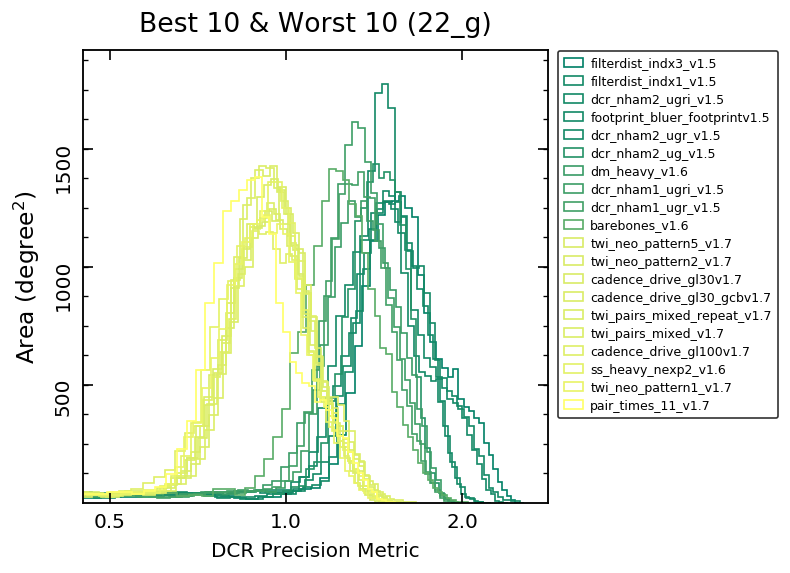

In [17]:
# plot distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)

# resort by metric value
summary_df_all = summary_df_all.sort_values('DCR_22_g_Median')

# create normalization object
gNormAll = mpl.colors.Normalize(vmin=summary_df_all['DCR_22_g_Median'].min(), 
                                vmax=summary_df_all['DCR_22_g_Median'].max())
bins = 60
density = False

# plot top 10
for run in summary_df_all.index[:10]:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'DCR_22_g'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(gNormAll(summary_df_all.loc[run, 'DCR_22_g_Median']))
    ax.hist(norm_metric_g/data, bins=bins, histtype='step', color=c, 
             density=density, label=f"{run.rsplit('_', 1)[0]}")

# plot worst 10
for run in summary_df_all.index[-10:]:
    
    # match keys
    keys = [*final_bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == 'DCR_22_g'][0]
    
    # need to mask the pixels that have no available data
    mask = final_bundleDicts[run][metricKey].metricValues.mask
    data = final_bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    c = mpl.cm.summer(gNormAll(summary_df_all.loc[run, 'DCR_22_g_Median']))
    ax.hist(norm_metric_g/data, bins=bins, histtype='step', color=c, 
             density=density, label=f"{run.rsplit('_', 1)[0]}")


# tick & format
ax.set_xscale('log', basex=10)
ax.set_xbound(lower=0.45, upper=2.8)
ax.tick_params(top=True, right=True, which='both')
ax.xaxis.set_major_locator(plt.FixedLocator([.5, 1, 2]))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(plt.NullLocator())

# label & legend
ax.set_xlabel('DCR Precision Metric', fontsize=12)
ax.legend(fontsize=7.5, bbox_to_anchor=(1.0, 1.02), edgecolor='k', loc=2, labelspacing=0.4)

ax.yaxis.set_major_locator(plt.FixedLocator(np.array([500, 1000, 1500, 2000])/(54.967783/60)**2))
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:.0f}'.format(x * (54.967783/60)**2) for x in y_vals], rotation=90)
ax.set_ylabel('Area ($\mathrm{degree^{2}}$)', labelpad=7)
plt.title('Best 10 & Worst 10 (22_g)')